In [278]:
nersc_reservation = None

import sys
sys.path.insert(0, "..")
from workshop.lessons.lesson_tools import fake_focalplane, check_nersc
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)


In [279]:
#akito's wide patch
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-05-01 00:00:00" \
    --stop "2020-05-03 00:00:00" \
    --patch-coord C \
    --patch large_patch,1,-30,-35,30,-60 \
    --el-min 30 \
    --el-max 90 \
    --ces-max-time 86400 \
    --out schedule.txt \
    --debug

TOAST INFO: Adding patch "large_patch"
TOAST INFO: Rectangular format
TOAST INFO: large_patch corners:
 lon = [-29.999999999999996, -29.999999999999996, -28.779225411238542, -27.55845082247709, -26.337676233715637, -25.116901644954183, -23.89612705619273, -22.675352467431274, -21.45457787866982, -20.233803289908366, -19.013028701146915, -17.79225411238546, -16.571479523624006, -15.350704934862552, -14.129930346101098, -12.909155757339645, -11.688381168578191, -10.467606579816737, -9.246831991055284, -8.02605740229383, -6.805282813532376, -5.584508224770922, -4.363733636009469, -3.142959047248015, -1.922184458486561, -0.7014098697251074, 0.5193647190363463, 1.7401393077978, 2.9609138965592536, 4.1816884853207075, 5.402463074082161, 6.623237662843615, 7.8440122516050685, 9.064786840366523, 10.285561429127977, 11.50633601788943, 12.727110606650884, 13.947885195412338, 15.16865978417379, 16.389434372935245, 17.6102089616967, 18.830983550458154, 20.051758139219608, 21.27253272798106, 22.493

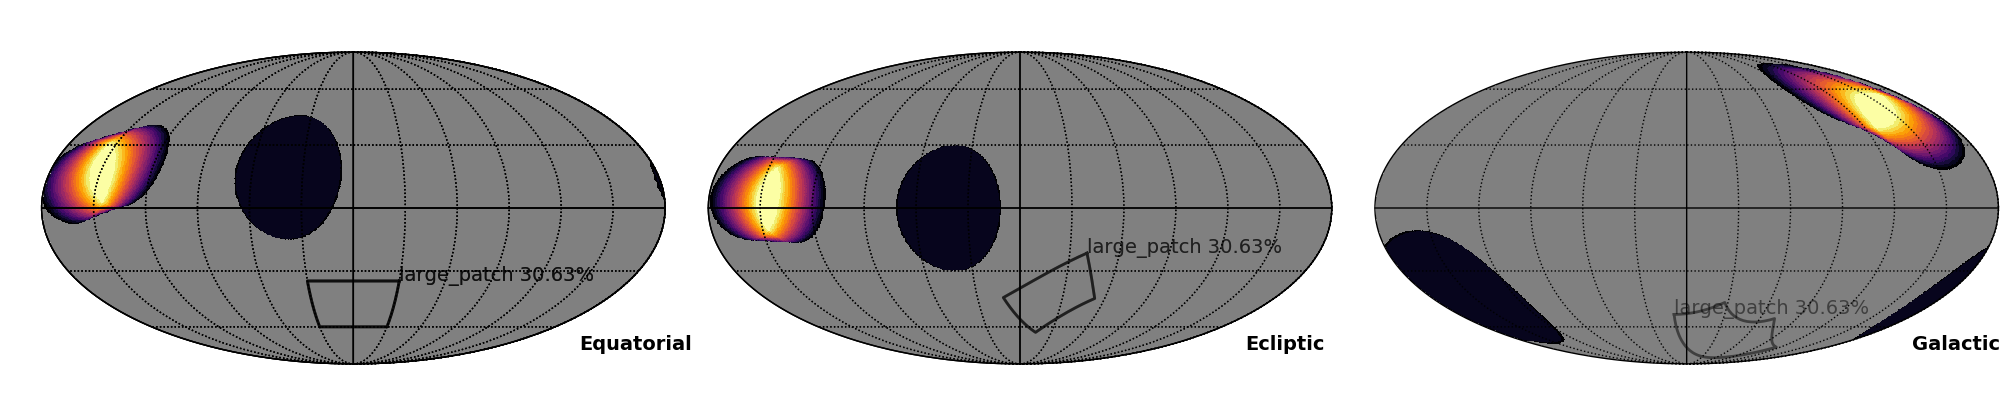

In [280]:
from IPython.display import Image
Image("patches.png")

In [243]:
%%writefile bin_schedule.par
--sample-rate
10
--scan-rate
0.3
--scan-accel
10.0
--nside
64
--focalplane
focalplane.pkl
--schedule
schedule.txt
--out
out
--simulate-noise
--freq
100
--no-destripe
--no-binmap
--hits
--wcov

Overwriting bin_schedule.par


In [244]:
%%writefile toast_ground_sim.slurm
#!/bin/bash
#SBATCH --partition=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=10
#SBATCH --job-name=toast_ground_sim
#SBATCH --licenses=SCRATCH
#SBATCH --constraint=haswell
#SBATCH --account=mp107

ulimit -c unlimited

export MALLOC_MMAP_THRESHOLD_=131072
export PYTHONSTARTUP=""
export PYTHONNOUSERSITE=1
export HOME=$SCRATCH

export OMP_NUM_THREADS=2
export OMP_PLACES=threads
export OMP_PROC_BIND=spread

let nnode=10
let ntask_node=32/$OMP_NUM_THREADS
let ntask=$nnode*$ntask_node
let ncore=2*$OMP_NUM_THREADS

srun -n $ntask -c $ncore --cpu_bind=cores \
    toast_ground_sim.py \
    @bin_schedule.par \
    >& toast_ground_sim.log

Overwriting toast_ground_sim.slurm


In [245]:
command = None

if nersc_host is not None:
    command = "sbatch toast_ground_sim.slurm"
else:
    # Just use mpirun
    command = "mpirun -np 4 toast_ground_sim.py @toast_ground_sim.par"

print(command, flush=True)
sp.check_call(command, stderr=sp.STDOUT, shell=True)

sbatch toast_ground_sim.slurm


0

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


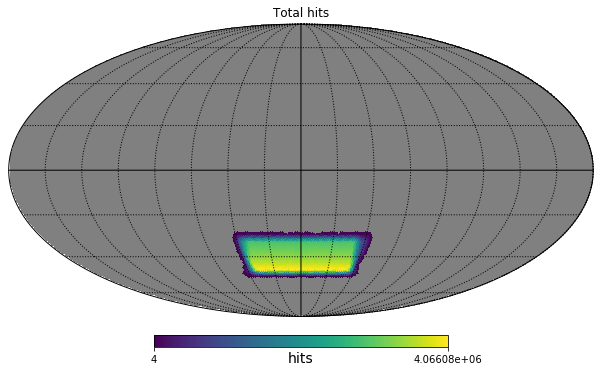

In [246]:
import matplotlib.pyplot as plt
%matplotlib inline
import healpy

hits = healpy.read_map("out/00000000/100/toast_100_telescope_all_time_all_hmap.fits")
hits[hits == 0] = healpy.UNSEEN
healpy.mollview(hits, unit="hits", title="Total hits")
healpy.graticule(22.5, verbose=False)


In [277]:
! cat schedule.txt


#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-05-01 07:20:00  2020-05-01 11:25:00    58970.305556   58970.475694 large_patch                           118.03   147.33    31.12 R       -48.84    92.91     6.67    70.28   -36.17   278.00   -85.80   177.35  0.56     0   0
 2020-05-01 12:16:40  2020-05-01 18:34:40    58970.511574   58970.774074 large_patch                           184.81   242.00    52.83 S        17.59    64.23    40.74   318.16   -77.59   108.06     4.32    68.44  0.59     1   0
 2020-05-02 07:16:20  2020-05-02 11:20:20    58971.303009   58971.472454 large_patch                           118.02   147.34    31.16 R       -49.

In [50]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-01 12:00:00" \
    --patch-coord C \
    --patch small_patch,1,40,-40,44,-44 \
    --out schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Rectangular format
TOAST INFO: Global timer: toast_ground_schedule:  0.18 seconds (1 calls)


In [262]:
! cat schedule.txt


#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 14:30:00  2020-01-01 19:55:00    58849.604167   58849.829861 large_patch                           118.19   141.42    30.16 R        61.40    96.31    44.13   259.62   -12.06   103.01    59.09    61.03  0.36     0   0
 2020-01-01 22:06:40  2020-01-02 03:52:40    58849.921296   58850.161574 large_patch                           214.17   242.96    44.14 S        14.84   250.93   -42.95   193.29    71.87   341.84     1.51   265.71  0.39     1   0
 2020-01-02 14:34:20  2020-01-02 19:58:20    58850.607176   58850.832176 large_patch                           117.97   141.52    31.51 R        62.

In [13]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-04 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,80,-13,10 \
    --patch large_patch,1,80,-33,20 \
    --el-min 30 \
    --el-max 60 \
    --ces-max-time 86400 \
    --sun-avoidance-angle 20 \
    --out schedule.txt \
    --debug

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Adding patch "large_patch"
TOAST INFO: Center-and-width format
TOAST INFO: small_patch corners:
 lon = [80.0, 82.52889698392441, 84.40387023305097, 85.13152053896695, 84.49355559956005, 82.61888616230056, 80.0, 77.38111383769943, 75.50644440043996, 74.86847946103305, 75.596129766949, 77.47110301607557, 80.0]
 lat= [-8.000000000000002, -8.669872981077807, -10.5, -13.0, -15.5, -17.33012701892219, -18.0, -17.330127018922195, -15.500000000000002, -13.000000000000002, -10.500000000000004, -8.66987298107781, -8.000000000000002]
TOAST INFO: large_patch corners:
 lon = [80.0, 85.48776585034872, 89.80834435462137, 91.92363292835948, 90.99002012118036, 86.69254923971052, 80.0, 73.3074507602895, 69.00997987881962, 68.07636707164052, 70.19165564537862, 74.51223414965126, 80.0]
 lat= [-23.0, -24.339745962155618, -28.0, -33.0, -38.0, -41.66025403784439, -43.0, -41.66025403784439, -38.00000000000001, -33.0, -28.000

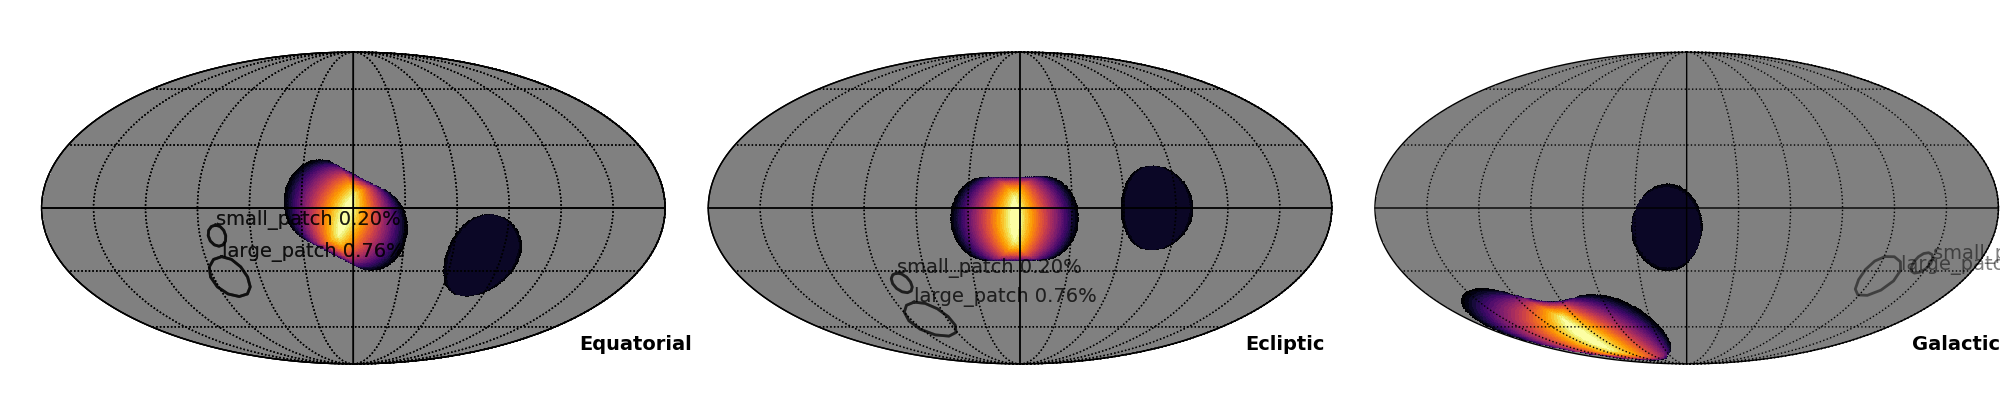

In [14]:
from IPython.display import Image
Image("patches.png")

In [32]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-04 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,80,-13,10 \
    --patch large_patch,1,80,-33,20 \
    --el-min 30 \
    --el-max 60 \
    --ces-max-time 86400 \
    --sun-avoidance-angle 20 \
    --equalize-area \
    --equalize-time \
    --out schedule.txt

! cat schedule.txt

usage: toast_ground_schedule.py [-h] [--site-name SITE_NAME]
                                [--telescope TELESCOPE] [--site-lon SITE_LON]
                                [--site-lat SITE_LAT] [--site-alt SITE_ALT]
                                [--scan-margin SCAN_MARGIN]
                                [--ra-period RA_PERIOD]
                                [--ra-amplitude RA_AMPLITUDE]
                                [--dec-period DEC_PERIOD]
                                [--dec-amplitude DEC_AMPLITUDE]
                                [--elevation-penalty-limit ELEVATION_PENALTY_LIMIT]
                                [--elevation-penalty-power ELEVATION_PENALTY_POWER]
                                [--equalize-area] [--equalize-time]
                                [--equalize-scans] --patch PATCH
                                [--patch-coord PATCH_COORD] [--el-min EL_MIN]
                                [--el-max EL_MAX] [--el-step EL_STEP]
                                [--a

In [28]:
# ! toast_fake_focalplane.py \
#     --minpix 20 \
#     --out focalplane \
#     --fwhm 30 \
#     --fov 10 \
#     --psd_fknee 5e-2 \
#     --psd_NET 1e-3 \
#     --psd_alpha 1 \
#     --psd_fmin 1e-5

In [70]:
%%writefile bin_schedule.par
--sample-rate
150
--scan-rate
0.3
--scan-accel
10.0
--nside
64
--focalplane
focalplane.pkl
--schedule
schedule.txt
--out
out
--simulate-noise
--freq
100
--no-destripe
--no-binmap
--hits
--wcov

Overwriting bin_schedule.par


In [71]:
%%writefile toast_ground_sim.slurm
#!/bin/bash
#SBATCH --partition=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=10
#SBATCH --job-name=toast_ground_sim
#SBATCH --licenses=SCRATCH
#SBATCH --constraint=haswell
#SBATCH --account=mp107

ulimit -c unlimited

export MALLOC_MMAP_THRESHOLD_=131072
export PYTHONSTARTUP=""
export PYTHONNOUSERSITE=1
export HOME=$SCRATCH

export OMP_NUM_THREADS=2
export OMP_PLACES=threads
export OMP_PROC_BIND=spread

let nnode=10
let ntask_node=32/$OMP_NUM_THREADS
let ntask=$nnode*$ntask_node
let ncore=2*$OMP_NUM_THREADS

srun -n $ntask -c $ncore --cpu_bind=cores \
    toast_ground_sim.py \
    @bin_schedule.par \
    >& toast_ground_sim.log

Overwriting toast_ground_sim.slurm


In [72]:
command = None

if nersc_host is not None:
    command = "sbatch toast_ground_sim.slurm"
else:
    # Just use mpirun
    command = "mpirun -np 4 toast_ground_sim.py @toast_ground_sim.par"

print(command, flush=True)
sp.check_call(command, stderr=sp.STDOUT, shell=True)

sbatch toast_ground_sim.slurm


0

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


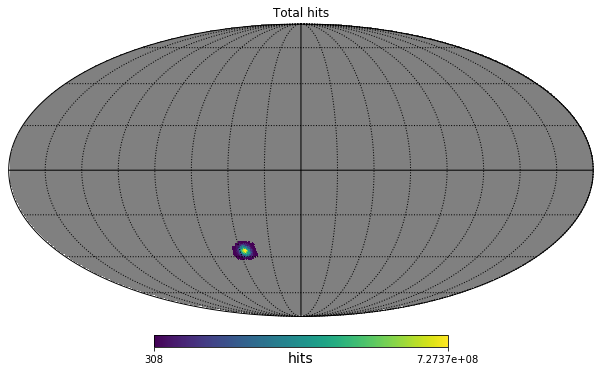

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
import healpy

hits = healpy.read_map("out/00000000/100/toast_100_telescope_all_time_all_hmap.fits")
hits[hits == 0] = healpy.UNSEEN
healpy.mollview(hits, unit="hits", title="Total hits")
healpy.graticule(22.5, verbose=False)


In [27]:

# wcov = healpy.read_map("out/00000000/100/toast_100_telescope_all_time_all_wcov.fits")
# wcov *= 1e12  # from K^2 to uK^2
# wcov[wcov == 0] = healpy.UNSEEN
# healpy.mollview(wcov, unit="$\mu$K$^2$", title="White noise variance", min=1e0, max=1e3)
# healpy.graticule(22.5, verbose=False)